<a href="https://colab.research.google.com/github/Srijavali/Ai-ml-projects-labs-submission/blob/main/Module_2_Lab_3_Manifold_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

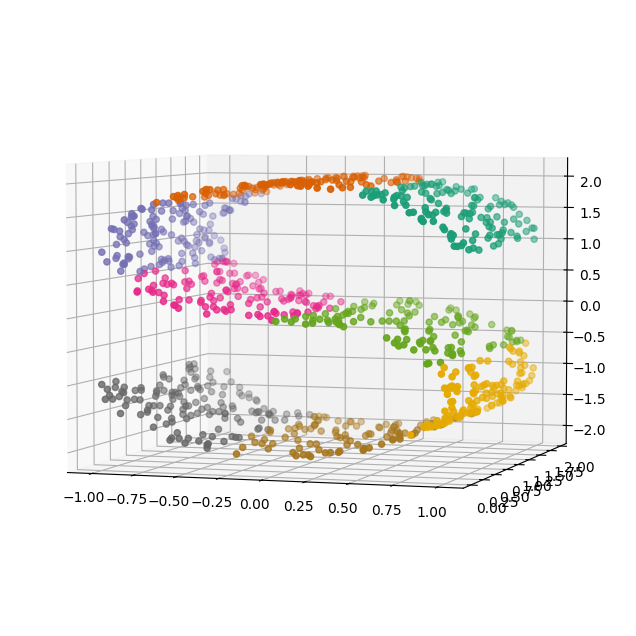

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

In [4]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(1000, 1000)


In [5]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [6]:
neighbors.shape

(1000, 1000)

In [17]:
from scipy.sparse.csgraph import shortest_path
graph = shortest_path(neighbors, directed=True)

In [18]:
gram = (graph ** 2)

In [19]:
n_samples = gram.shape[0]
print(n_samples)
# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

1000


In [20]:
gram

array([[ -0.88398641,  -1.47497962,  -1.31311864, ...,  -4.47957298,
          2.49544709,  -1.83986044],
       [ -1.49884874, -11.16038284,  -4.33296394, ..., -19.07471429,
         11.91717476,  -7.32790937],
       [ -1.2694376 ,  -4.27601767,  -2.33904998, ...,  -9.25297791,
          5.59994681,  -3.66168351],
       ...,
       [ -4.03480323, -18.50726059,  -8.21640904, ..., -38.50429553,
         23.38021994, -15.28974654],
       [  2.49301612,  11.65922277,   5.60189096, ...,  23.53002322,
        -14.22844175,   9.55871653],
       [ -2.02244594,  -8.39136954,  -4.15052047, ..., -16.33028134,
         10.61363536,  -7.07120812]])

In [21]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

<ipython-input-21-b919cb92c160>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]


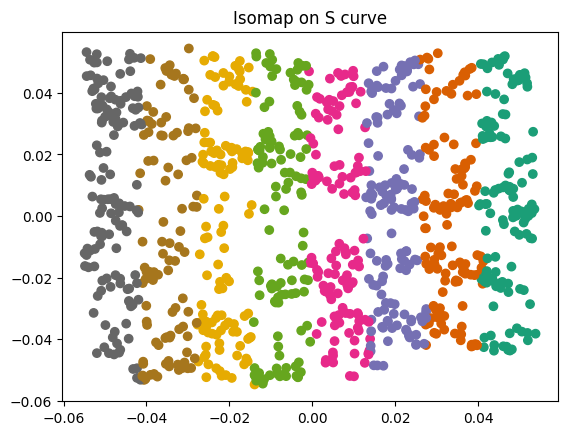

In [22]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('on')
plt.show()

In [24]:
from sklearn.manifold import Isomap

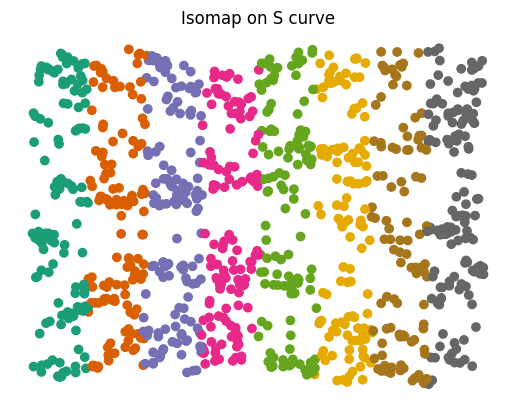

In [25]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)
ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [26]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

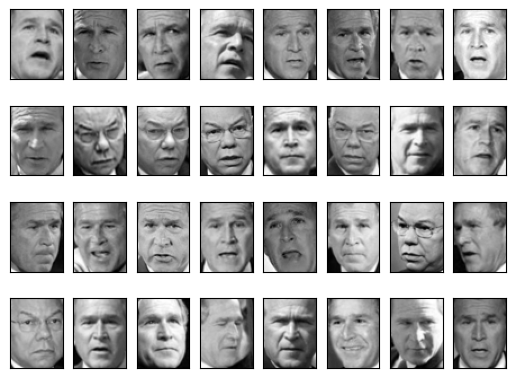

In [27]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

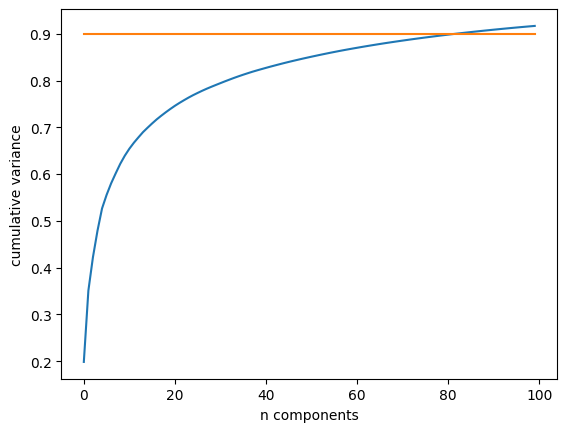

In [28]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [29]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [30]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

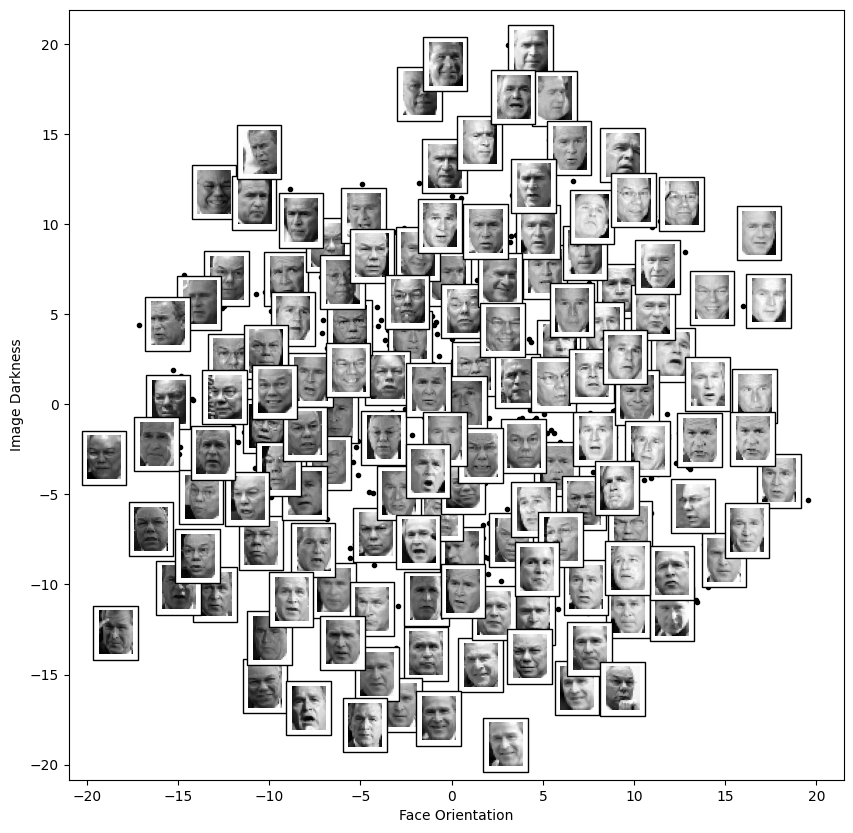

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 10),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Loading dataset...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Running Isomap...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

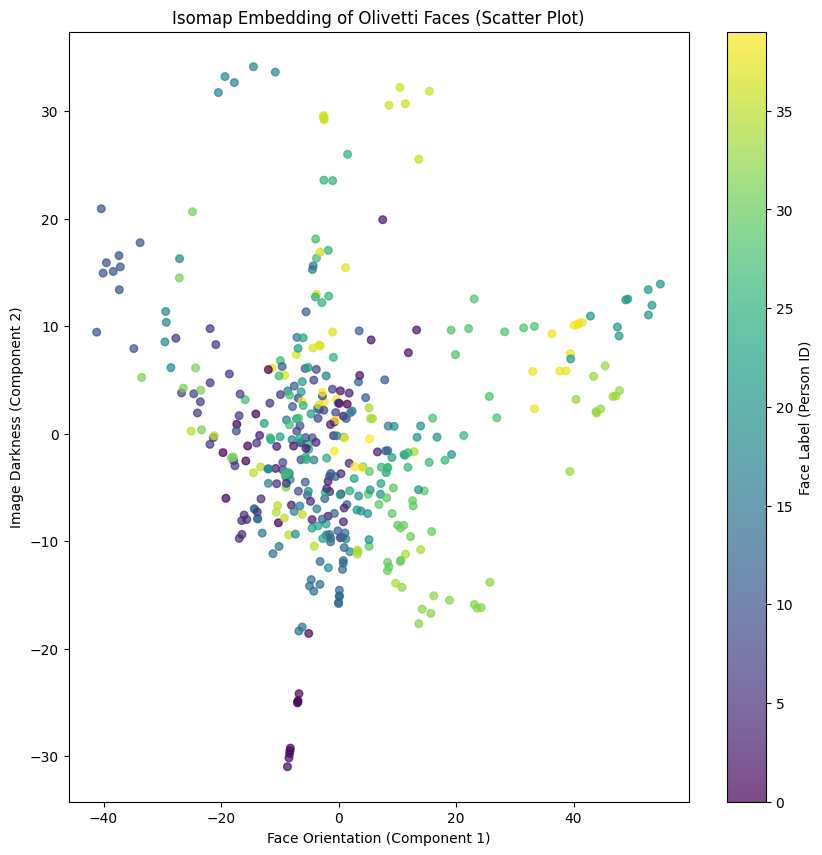

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.datasets import fetch_olivetti_faces

# Load the Olivetti Faces dataset
print("Loading dataset...")
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
data, images = faces.data, faces.images

# Apply Isomap for dimensionality reduction
print("Running Isomap...")
isomap = Isomap(n_neighbors=5, n_components=2)
embedding = isomap.fit_transform(data)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1], c=faces.target, cmap='viridis', s=30, alpha=0.7
)
plt.colorbar(scatter, label="Face Label (Person ID)")
plt.xlabel("Face Orientation (Component 1)")
plt.ylabel("Image Darkness (Component 2)")
plt.title("Isomap Embedding of Olivetti Faces (Scatter Plot)")
plt.show()


In [41]:
import numpy as np
import plotly.express as px
from sklearn.manifold import Isomap
from sklearn.datasets import fetch_olivetti_faces

# Load the Olivetti Faces dataset
print("Loading dataset...")
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
data, labels = faces.data, faces.target

# Apply Isomap for dimensionality reduction
print("Running Isomap...")
isomap = Isomap(n_neighbors=5, n_components=3)
embedding = isomap.fit_transform(data)

# Create a DataFrame for Plotly (optional, for better label handling)
import pandas as pd
df = pd.DataFrame({
    "Component 1": embedding[:, 0],
    "Component 2": embedding[:, 1],
    "Component 3": embedding[:, 2],
    "Label": labels
})

# Create the 3D scatter plot
fig = px.scatter_3d(
    df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Label",
    title="3D Isomap Embedding of Olivetti Faces",
    color_continuous_scale='Viridis',
    labels={"Label": "Person ID"},
    opacity=0.7
)

# Customize the layout
fig.update_traces(marker=dict(size=5))  # Adjust marker size
fig.update_layout(
    scene=dict(
        xaxis_title="Component 1",
        yaxis_title="Component 2",
        zaxis_title="Component 3"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()


Loading dataset...
Running Isomap...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

```
Answer
```


* if k value is very large overemphasis of global information takes place as we are trying to increase the no.of neibhours to a point while we are considering so, the manifold looses its details
  
* if k is too small, the neighborhood graph may become disconnected, leading to separate components. This prevents Isomap from computing meaningful geodesic distances between all points and makes the embedding highly sensitive to the noises.

When is the ISOMAP algorithm superior to PCA?

```
# Answer
```
when we consider the data which is in

*   Nonlinear manifold structure
*   incase of Global Structure preservation
*   Incase of Local Structure preservation
Isomap is superior when compared to pca and pca can be most effectively used in case of linear Structured data and it is superior incase of scalability and Robustness when compared to the Isomap.




Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference

```
Answer
```


*   Locally Linear Embedding (LLE)
* **Key Difference** ----> Unlike ISOMAP, LLE focuses on preserving local geometry rather than global distances, making it suitable for datasets with non-linear local structures but less effective at preserving the overall shape of the manifold.
*   Laplacian Eigenmaps
* **Key Difference** ---->  It focuses on preserving local connectivity and is ideal for data with a clear manifold structure, though it cannot easily handle out-of-sample extensions.
* t-Distributed Stochastic Neighbor Embedding (t-SNE)
* **Key Difference** ----> It is highly effective for visualizing clusters in high-dimensional data but is computationally expensive and does not directly provide a mapping for new data​
* Kernel Principal Component Analysis (KPCA)
* **Key Difference** ----> It generalizes PCA for nonlinear embeddings but relies heavily on choosing an appropriate kernel function
* Multidimensional Scaling (MDS)
* **Key Difference** ----> While effective for global relationships, it struggles with non-linear manifolds compared to methods like ISOMAP and LLE
* We can use so many methods instead of ISOMAPS but every method had their Pros and Cons.



Suggest ways to deal with missing data in manifold learning.

```
# Answer
```
* Mean/Median Imputation: Replace missing values with the mean or median of the feature. and it may not capture complex data patterns.
* we can consider the nearest neibhours of the missing data
* Methods like Singular Value Decomposition (SVD) or Iterative PCA can be used to fill in missing entries by reconstructing the data matrix.
* By training the regression models like Randomforest to predict the missing values and filling those predicted values in place of missing values.
* By using Robust Manifold Learning Algorithms as these are designed to handle missing data.
* Iterative Manifold Learning with Missing Data
* Sparse Manifold Learning
* Reduce Dependence on Global Pairwise Distances as some methods mainly depends upon the geodesic distance. like t-sne


